In [ ]:
%matplotlib inline 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re 
import numpy as np
import os
import pandas as pd
from pyspark.sql import SparkSession, SQLContext, Row
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import mean, stddev
from scipy.sparse import coo_matrix
import json
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.sql.functions import udf

from pyspark.mllib.clustering import KMeans, KMeansModel

import re

## Song embeddings

In [2]:
#Read GLove vectors

vocab_file = 'GloVe/song-vocab.txt'
vectors_file = 'GloVe/song-vectors.txt'
with open(vocab_file, 'r') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]
        
vocab = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}

In [4]:
song_to_id = '/project/cmsc25025/playlist/song_hash.txt'
song_to_tags = '/project/cmsc25025/playlist/song-to-tags.txt'
tags_to_id = '/project/cmsc25025/playlist/tag_hash.txt'

In [5]:
with open(tags_to_id, 'r') as f:
    tag_id = {}
    for line in f:
        vals = line.rstrip().split(',')
        tag_id[vals[0]] = vals[1]

In [6]:
with open(song_to_id, 'r') as f:
    song_id = {}
    for line in f:
        vals = line.rstrip().split('\t')
        song_id[vals[0]] = vals[1]

In [7]:
song_id['2']

'Get Back Up (w\\/ Chris Brown)'

In [8]:
conf = SparkConf()
conf.set("spark.driver.maxResultSize", "3g")
# start spark master program on this machine and register worker nodes
os.system('start-spark-slurm.sh&') # use & to put it into background

# get ip address of this machine
ip = os.popen('hostname -i').read().strip('\n')
print 'Spark Master web UI: http://{}:8080'.format(ip)

spark = SparkSession.builder.master('local[60]').appName('songs').getOrCreate()


Spark Master web UI: http://10.50.221.146:8080


In [9]:
df = spark.sparkContext.parallelize([
    [k] + [v]
    for k, v in  vectors.items()]).toDF(['song_id', 'vector'])

df.show()

+-------+--------------------+
|song_id|              vector|
+-------+--------------------+
|   5988|[0.001819, 0.0028...|
|   5989|[-0.001189, -0.00...|
|   5982|[-0.003241, -0.00...|
|   5983|[-4.26E-4, -0.001...|
|   5980|[5.31E-4, -0.0054...|
|   5981|[4.68E-4, 0.00236...|
|   5986|[-6.11E-4, 0.0023...|
|   5987|[-3.22E-4, -6.39E...|
|   5984|[0.001018, -6.95E...|
|   5985|[-2.02E-4, -4.41E...|
|   6796|[0.003671, 0.0061...|
|   6797|[0.001251, 0.0026...|
|   6794|[3.78E-4, 0.00429...|
|   6795|[0.007444, 0.0046...|
|   6792|[0.001788, 0.0012...|
|   6793|[0.013751, 0.0278...|
|   6790|[0.00497, 0.0037,...|
|   6791|[0.013417, 0.0134...|
|   6798|[0.001222, 0.0020...|
|   6799|[0.005283, 0.0032...|
+-------+--------------------+
only showing top 20 rows



### Conducting K-means to visualize most common tags
Perform k-means on the song embeddings with k = 5. For each cluster, print the top 5
most commonly occurring tags and comment on the results.

In [10]:
from pyspark.mllib.clustering import KMeans, KMeansModel

parsedData = df.rdd.map(lambda line: np.array(line['vector']))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 5, maxIterations=10, initializationMode="random")

In [11]:
cluster_udf = udf(lambda x: clusters.predict(x))

df_new = df.select(df["song_id"], df["vector"],
    cluster_udf(df["vector"]).alias("clusters"))
df_new.show()

+-------+--------------------+--------+
|song_id|              vector|clusters|
+-------+--------------------+--------+
|   5988|[0.001819, 0.0028...|       4|
|   5989|[-0.001189, -0.00...|       4|
|   5982|[-0.003241, -0.00...|       4|
|   5983|[-4.26E-4, -0.001...|       4|
|   5980|[5.31E-4, -0.0054...|       4|
|   5981|[4.68E-4, 0.00236...|       4|
|   5986|[-6.11E-4, 0.0023...|       4|
|   5987|[-3.22E-4, -6.39E...|       4|
|   5984|[0.001018, -6.95E...|       4|
|   5985|[-2.02E-4, -4.41E...|       4|
|   6796|[0.003671, 0.0061...|       4|
|   6797|[0.001251, 0.0026...|       4|
|   6794|[3.78E-4, 0.00429...|       4|
|   6795|[0.007444, 0.0046...|       4|
|   6792|[0.001788, 0.0012...|       4|
|   6793|[0.013751, 0.0278...|       4|
|   6790|[0.00497, 0.0037,...|       4|
|   6791|[0.013417, 0.0134...|       0|
|   6798|[0.001222, 0.0020...|       4|
|   6799|[0.005283, 0.0032...|       4|
+-------+--------------------+--------+
only showing top 20 rows



We check the distribution of the clusters

In [12]:
counts = df_new.groupBy(['clusters']).count().alias('counts')
counts.show()

+--------+-----+
|clusters|count|
+--------+-----+
|       3|  480|
|       0|  885|
|       1|  106|
|       4| 7663|
|       2|  632|
+--------+-----+



We read the song tags into a dataframe

In [13]:
textFile = spark.read.text(song_to_tags)

In [14]:
t1 = textFile.rdd.map(lambda x: x['value'].split("\t")) 
tag_songs = t1.map(lambda p: Row(song_id = p[0], labels = [i for i in p[1].split(",")]))
tag_songs.take(10)
schematags = spark.createDataFrame(tag_songs)
schematags.show()

+--------------------+-------+
|              labels|song_id|
+--------------------+-------+
|           [15, 249]|   5988|
|                 [#]|   5989|
|                 [#]|   5982|
|                 [#]|   5983|
|                 [#]|   5980|
|                 [#]|   5981|
|      [15, 198, 249]|   5986|
|                 [#]|   5987|
|[5, 17, 50, 83, 1...|   5984|
|                 [#]|   5985|
|[0, 1, 2, 4, 6, 8...|   6796|
|[0, 5, 6, 7, 12, ...|   6797|
|[0, 1, 2, 3, 4, 6...|   6794|
|                 [#]|   6795|
|[0, 1, 2, 3, 4, 6...|   6792|
|[0, 1, 2, 3, 4, 6...|   6793|
|[0, 1, 2, 3, 4, 6...|   6790|
|[0, 1, 2, 4, 8, 9...|   6791|
|[0, 1, 2, 3, 4, 5...|   6798|
|[0, 1, 2, 3, 4, 6...|   6799|
+--------------------+-------+
only showing top 20 rows



In [15]:
data = df_new.join(schematags, "song_id", how = "outer")
data.show()

+-------+--------------------+--------+--------------------+
|song_id|              vector|clusters|              labels|
+-------+--------------------+--------+--------------------+
|   1090|[-0.025895, 0.032...|       3|[26, 32, 39, 41, ...|
|   1159|[0.004977, -0.002...|       4|[0, 1, 2, 7, 11, ...|
|   1436|[-0.002367, 0.005...|       4|                 [0]|
|   1512|[0.001189, 0.0135...|       0|[0, 2, 3, 4, 5, 6...|
|   1572|[-0.002166, -0.00...|       4|[0, 2, 3, 4, 6, 7...|
|   2069|[7.87E-4, 0.00658...|       4|[0, 1, 2, 3, 4, 5...|
|   2088|[3.03E-4, -0.0369...|       4|[0, 1, 2, 3, 4, 6...|
|   2136|[-0.001815, 0.002...|       4|[0, 1, 2, 4, 5, 6...|
|   2162|[-0.006937, 0.010...|       4|[0, 1, 2, 4, 5, 6...|
|   2294|[0.001155, -0.003...|       4|[0, 1, 2, 8, 10, ...|
|   2904|[-0.00699, -0.007...|       4|       [23, 54, 114]|
|    296|[0.001508, -0.001...|       4|    [22, 24, 69, 82]|
|   3210|[-0.003786, 0.011...|       4|[0, 2, 5, 6, 8, 1...|
|   3414|[-0.009673, -0.

In [16]:
results = data.rdd.filter(lambda x: x['labels'] is not None)

In [17]:
def top_tags( results, k):
    results_0 = results.filter(lambda x: x['clusters'] == k).map(lambda x: [(v,1) for v in x['labels']]).flatMap(lambda xs: [x for x in xs])
    tuple_0 = results_0.reduceByKey(lambda x,y: x + y).collect()
    list_0 = filter( lambda x: x[0] != '#', sorted(tuple_0, key = lambda x: x[1], reverse = True)[:6] )
    top_5_0 = []
    for tag, count in list_0:
        top_5_0.append((tag_id[tag],count))

    return top_5_0
    

The results shown below indicate that there are clearly two clusters which have different labels, this are some related to christian/religious music and some to country music. However, the other three clusters have similar tags (rock, pop, love). This could indicate that perhaps that are subtags within rock, pop, etc that could help identify better the uniqueness of the cluster. As well, as it indicates the fact that this type of genres are the most popular and thus have a high presence.

In [18]:
top_tags(results, '0')

[(' rock', 452),
 (' favorites', 415),
 (' pop', 387),
 (' love', 341),
 (' american', 334),
 (' male vocalists', 324)]

In [19]:
top_tags(results, '1')

[(' christian', 87),
 (' christian rock', 74),
 (' contemporary christian', 58),
 (' worship', 53),
 (' rock', 52),
 (' favorites', 37)]

In [20]:
top_tags(results, '2')

[(' pop', 325),
 (' favorites', 276),
 (' love', 271),
 (' rock', 256),
 (' american', 223),
 (' male vocalists', 211)]

In [21]:
top_tags(results, '3')

[(' country', 379),
 (' my favorite', 241),
 (' great song', 220),
 (' classic country', 209),
 (' beautiful', 171),
 (' favorites', 155)]

In [22]:
top_tags(results, '4')

[(' rock', 2712),
 (' pop', 2600),
 (' favorites', 2403),
 (' male vocalists', 1941),
 (' love', 1819)]

### Do T-SNE reduction

Similar to the word embeddings question, use the t-SNE dimensionality reduction technique
to visualize the song embeddings. Find an area of the plot that makes sense, save
the plot for the graders, and discuss the area you landed on.

In [23]:
#Filter unknown data

data_Tsne = data.rdd.filter(lambda x: x["song_id"] != u'<unk>')

In [24]:
data_Tsne = data_Tsne.filter(lambda x: isinstance(x['vector'] , list))

In [25]:
W = np.array(data_Tsne.map(lambda x: x['vector']).collect())

In [26]:
songs = data_Tsne.map(lambda x: song_id[x['song_id']]).collect()

The T-SNE reduction shows a big cloud of songs mapped in two dimensions. I chose one area that seems to concentrate 80's rock with songs such as Highway to Hell, Big Balls and Send the pain below

<IPython.core.display.Javascript object>


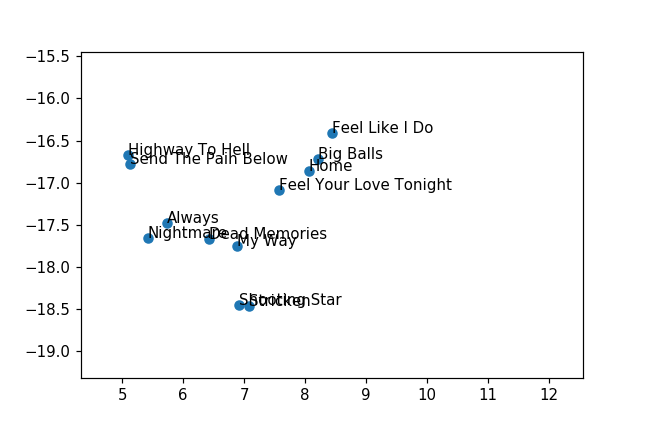

In [46]:
%matplotlib notebook

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(W[:1000][:])
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(songs, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0),
    textcoords= 'offset points')
plt.show()

## Artist embeddings

In [28]:
#Read GLove vectors

vocab_file = 'GloVe/artist-vocab.txt'
vectors_file = 'GloVe/artist-vectors.txt'
with open(vocab_file, 'r') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]
        
vocab_artist = {w: idx for idx, w in enumerate(words)}
ivocab_artist = {idx: w for idx, w in enumerate(words)}

In [29]:
artist_to_id = '/project/cmsc25025/playlist/artist_hash.txt'

with open(artist_to_id, 'r') as f:
    artist_id = {}
    for line in f:
        vals = line.rstrip().split('\t')
        artist_id[vals[0]] = vals[1]

In [30]:
with open(artist_to_id, 'r') as f:
    id_artist = {}
    for line in f:
        vals = line.rstrip().split('\t')
        id_artist[vals[1]] = vals[0]

In [31]:
artist_df = spark.sparkContext.parallelize([
    [k] + [v]
    for k, v in  vectors.items()]).toDF(['artist_id', 'vector'])

artist_df.show()

+---------+--------------------+
|artist_id|              vector|
+---------+--------------------+
|     1200|[-5.27E-4, -0.010...|
|     1615|[-0.211298, -0.55...|
|      344|[-0.139281, 0.001...|
|      345|[-0.112396, 0.047...|
|      346|[0.158081, 0.1217...|
|      347|[0.491232, -0.412...|
|      340|[-0.458626, 0.038...|
|      341|[-0.278013, 0.058...|
|      342|[-0.212128, -0.07...|
|      343|[-1.130705, -0.48...|
|      348|[0.09615, 0.14707...|
|      349|[-0.217686, -0.34...|
|     2185|[-0.149094, 0.101...|
|      512|[-0.047254, 0.002...|
|     2318|[-0.17507, -0.277...|
|     2319|[-0.193818, 0.306...|
|     2316|[-0.103912, -0.18...|
|     2317|[0.10358, 0.44513...|
|     2314|[-0.27438, -0.049...|
|     2315|[-0.176941, 0.091...|
+---------+--------------------+
only showing top 20 rows



(d) Find the 5 closest artist embedding vectors to the following artists: ‘The Beatles’,
‘The Red Hot Chili Peppers’, and ‘Usher’. Comment on the results.

In [33]:
list_ids = [id_artist["Usher"], id_artist["The Beatles"], id_artist["The Red Hot Chili Peppers"]]

In [37]:
def top_5_artists(artist_df, id_a):
    #Get vector for artist of interest 
    interest_vector = artist_df.rdd.filter(lambda x: x['artist_id'] == id_a).map(lambda x: x['vector']).take(1)[0]
    
    #Get cosine similarity
    cosine = artist_df.rdd.map(lambda x: cosine_similarity(interest_vector, x['vector']))
    id_ = artist_df.rdd.map(lambda x: x['artist_id'])
    results = cosine.zip(id_).collect()
    
    #Get top 5 results 
    top5 = sorted(results, key = lambda x: x[0], reverse = True)[1:6]
    top5_list = []
    for sim, id_ in top5:
        top5_list.append((artist_id[id_], sim))
    
    return top5_list


    

The results of the top 5 artists based on cosine similarity indicate intuitive results. Usher, for instance, is assigned close to R&B/rap musicians such as Rihanna and B.o.B. Likewise, Red Hot Chilli Peppers is close to 90's rock bands such as Pearl Jam and Nirvana. A less intuitive results is the Beatles which has groups that I wouldn't normally identify close to The Beatles such as Stealers Wheel and the Kinks. I guess I would have expected more bands like The Monkeys, Simon & Garfunkel, etc. Partially, this was a surprising result and could be explained due to high popularity of the Beatles in playlists


Top 5 artists for usher

In [38]:
top_5_artists(artist_df, id_artist["Usher"])

[('B.o.B', array([[ 0.92818406]])),
 ('Far East Movement', array([[ 0.91802633]])),
 ('B.o.B.', array([[ 0.9055274]])),
 ('Rihanna', array([[ 0.89849657]])),
 ('The Game', array([[ 0.88554665]]))]

Top 5 for The Beatles

In [39]:
top_5_artists(artist_df, id_artist["The Beatles"])


[('Creedence Clearwater Revival', array([[ 0.91859124]])),
 ('Stealers Wheel', array([[ 0.90859794]])),
 ('Norman Greenbaum', array([[ 0.84358826]])),
 ('The Kinks', array([[ 0.84262028]])),
 ('Grand Funk Railroad', array([[ 0.83269477]]))]

Top 5 for Red Hot Chili Peppers

In [40]:
top_5_artists(artist_df, id_artist["The Red Hot Chili Peppers"])

[('Stone Temple Pilots', array([[ 0.94843318]])),
 ('Pearl Jam', array([[ 0.94787237]])),
 ('Nirvana', array([[ 0.94529455]])),
 ('Sublime', array([[ 0.92706232]])),
 ('The Beastie Boys', array([[ 0.91085283]]))]

(e) Similar to the word embeddings question, use the t-SNE dimensionality reduction technique
to visualize the artist embeddings. Find an interesting area of the plot, save the
plot for the graders, and discuss the area you landed on.

In [41]:
#Filter unknown data

artist_Tsne = artist_df.rdd.filter(lambda x: x["artist_id"] != u'<unk>')

In [42]:
artist_Tsne = artist_Tsne.filter(lambda x: isinstance(x['vector'] , list))

In [43]:
W_artist = np.array(artist_Tsne.map(lambda x: x['vector']).collect())

In [44]:
artists = artist_Tsne.map(lambda x: artist_id[x['artist_id']]).collect()

In this case, I show a part of the T-Sne chart that shows reggaeton artists such as Daddy Yankee, Jerry Rivera, Omega. I thought it was interesting that this was a relatively isolated group. 

<IPython.core.display.Javascript object>


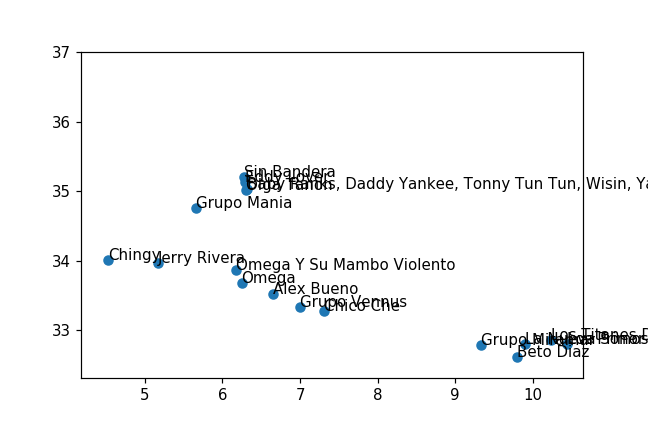

In [45]:
%matplotlib notebook

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(W_artist[:1000][:])
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(artists, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0),
    textcoords= 'offset points')
plt.show()